In [38]:
import sys,os
sys.path.append("./")
sys.path.append("../")
from src.Frame.exp_tool import Param
import src.Frame.exp_tool as ET

In [9]:

# from DMlib.cut_paste import get_cut_paste 



In [35]:
from  src.Data.anomaly_datasets import  MVTecAD

# from Dataset.transforms import RandomTranspose

from torchvision import  transforms
import numbers
import  collections
import random
from torchvision.transforms import functional as F
import torch
from PIL import Image
import  numpy as np
import math
  
from torchvision import transforms
import os
from torch.utils.data import DataLoader

# 1. create a  MVTec dataset object

In [45]:
DATA_ROOT_DIR = "/home/lyushuai/Datasets/mvtec_anomaly_detection_saliency"
all_types = ['bottle',
             'cable',
             'capsule',
             'carpet',
             'grid',
             'hazelnut',
             'leather',
             'metal_nut',
             'pill',
             'screw',
             'tile',
             'toothbrush',
             'transistor',
             'wood',
             'zipper']


from src.Frame import ComposeJoint,DatasetWrapper
from src.Data.transforms import RandomTranspose
augment_transform = ComposeJoint()
cj_param = 0.1
augment_transform.append(
    [transforms.ColorJitter(brightness=cj_param, contrast=cj_param, saturation=cj_param, hue=cj_param), None])
augment_transform.append(RandomTranspose())

train_data = MVTecAD(DATA_ROOT_DIR, 'hazelnut', transform = augment_transform, size=256,mode="train")

pre-loading images
loaded 391 images


dict_keys(['img', 'label', 'label_name', 'imagepath', 'saliency', 'mask'])
None


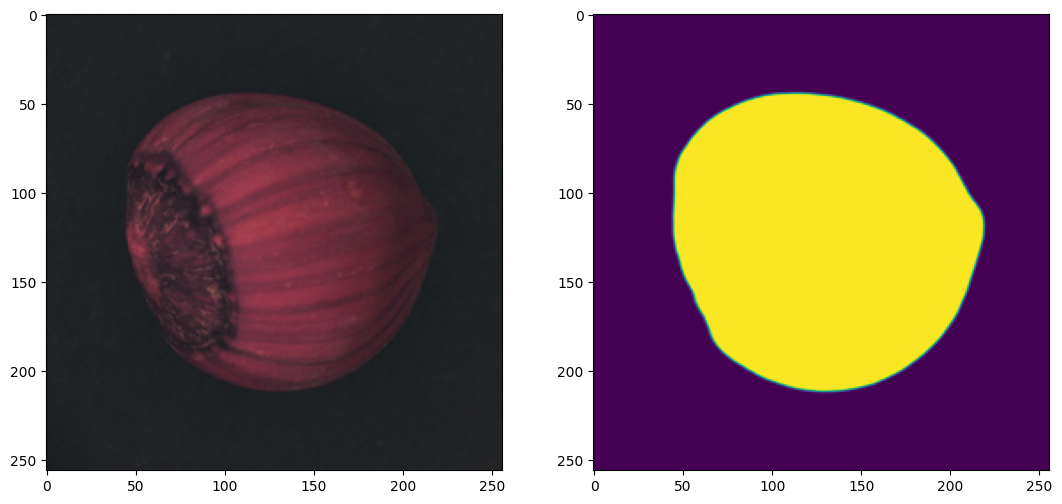

In [49]:
import matplotlib.pyplot as plt
def random_show_dataset(dataset):
     

    idx=random.randint(0,len(dataset)-1)
    item=dataset[idx]
    
    print(item.keys())
    
    saliency=item["saliency"]
    img=item["img"]
    mask=item["mask"]
    print(mask)
    plt.figure(figsize=(20,10))
    plt.subplot(131),plt.imshow(img)
    plt.subplot(132),plt.imshow(saliency)
    if mask:
        plt.subplot(133),plt.imshow(mask)
    
random_show_dataset(train_data)

# 2. create a DefectMaker wrapper

In [69]:
import src.DefectMaker.defect_makers as dm
from src.DefectMaker import *
def dm_com6(dataset):
    dms = {}
    dms = dm.merge_dict(dms, get_bezier_noise_dm(dataset))
    dms = dm.merge_dict(dms, get_bezierscar_noise_dm(dataset))
    dms = dm.merge_dict(dms, get_bezierclump_noise_dm(dataset))
    dms = dm.merge_dict(dms, get_bezier_cutpaste_dm(dataset))
    dms = dm.merge_dict(dms, get_bezierscar_cutpaste_dm(dataset))
    dms = dm.merge_dict(dms, get_bezierclump_cutpaste_dm(dataset))

    return functools.partial(dm.get_data_wrapper, dms=dms)
train_data.img_size=(256,256)
dm_wrapper = dm_com6(train_data)
dm_collate_param={"data_format":["img","class","mask"]}
dm_collate_param["key_label_map"]={"img":0,"img_bezier_cp":1,"img_bezier_scar_cp":2,"img_bezier_clump_cp":3
                                     ,"img_bezier_noise":4,"img_bezier_scar_noise":5,"img_bezier_clump_noise":6}

# 3. wrap the Mvtec dataset with  "dm_wrapper"

In [70]:
tensor_transform = transforms.Compose([])
tensor_transform.transforms.append(transforms.ToTensor())
tensor_transform.transforms.append(transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                                std=[0.5, 0.5, 0.5]))
        
train_loader_param=ET.Param()
train_loader_param.batch_size=96
train_loader_param.drop_last=True
train_loader_param.shuffle=True
train_loader_param.num_workers=8
train_loader_param.persistent_workers=True
train_loader_param.pin_memory=True
train_loader_param.prefetch_factor=5

wrappped_data = dm_wrapper(train_data, transform=tensor_transform, new_length=2000)
collate_func = wrappped_data.get_collate_func(**dm_collate_param)
dataloader = DataLoader(dataset=wrappped_data, collate_fn=collate_func, **train_loader_param)

dict_keys(['img', 'label', 'label_name', 'imagepath', 'saliency', 'mask', 'img_bezier_noise', 'img_bezier_scar_noise', 'img_bezier_clump_noise', 'img_bezier_cp', 'img_bezier_scar_cp', 'img_bezier_clump_cp'])


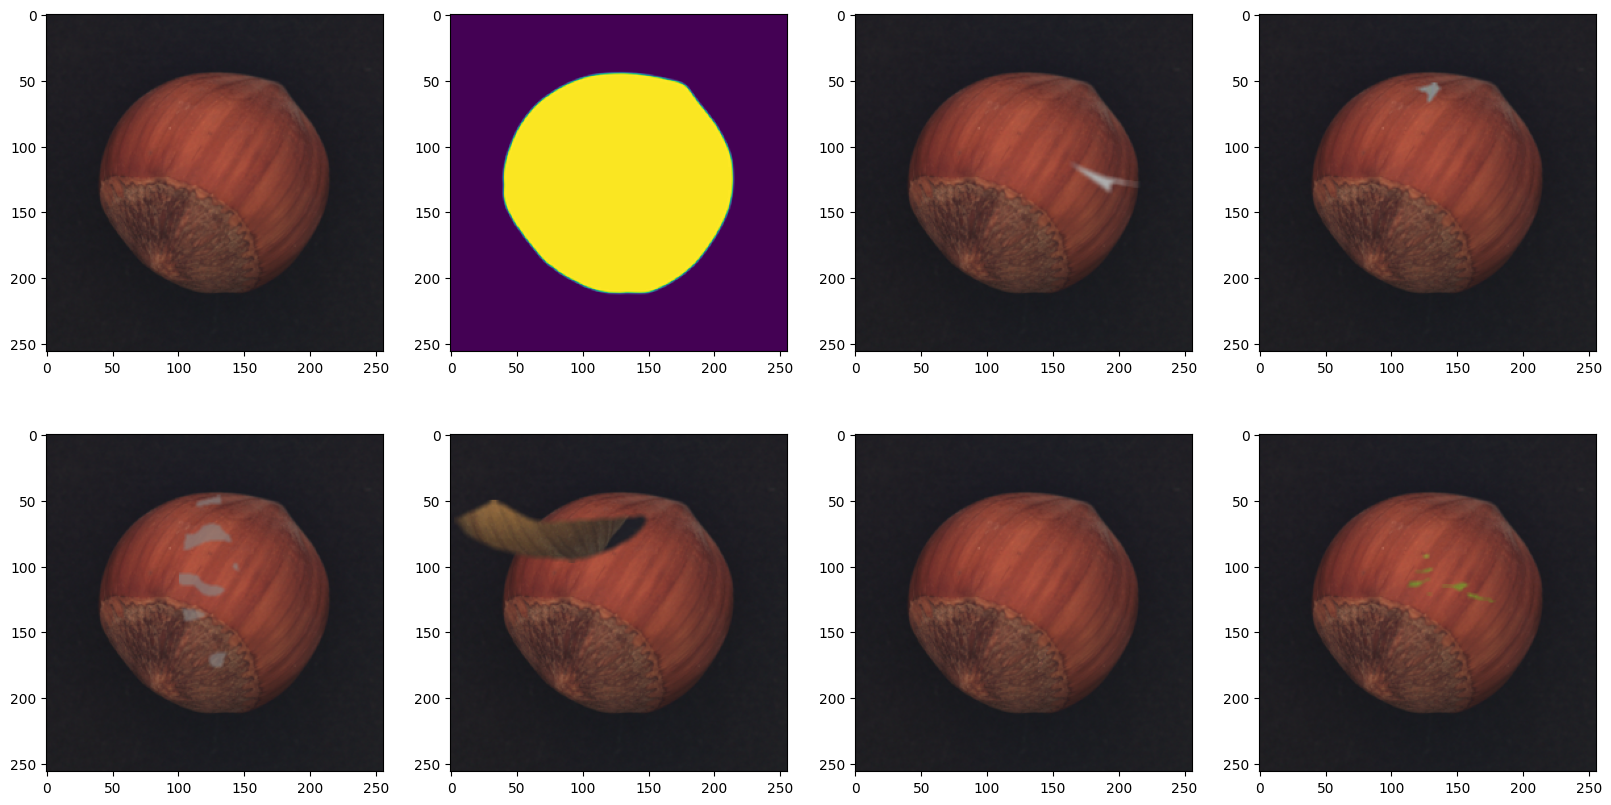

In [71]:
import matplotlib.pyplot as plt
from src.Frame.utils import ToNumpy,InverseNormalize
inverse_norm=InverseNormalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
tonum=ToNumpy(transpose=True)

def to_img(tensor3d):
    return tonum(inverse_norm(tensor3d[None]))[0]
def random_show_dataset(dataset):
     

    idx=random.randint(0,len(dataset)-1)
    item=dataset[idx]
    
    print(item.keys())
    saliency=item["saliency"]
    img=to_img(item["img"])
    defect_keys=[ 'img_bezier_noise', 'img_bezier_scar_noise', 'img_bezier_clump_noise', 
                 'img_bezier_cp', 'img_bezier_scar_cp', 'img_bezier_clump_cp'   ]
    defects=[ to_img(item[key])    for key in defect_keys ]
    plt.figure(figsize=(20,10))
    plt.subplot(241),plt.imshow(img)
    plt.subplot(242),plt.imshow(saliency)
    plt.subplot(243),plt.imshow(defects[0])
    plt.subplot(244),plt.imshow(defects[1])
    plt.subplot(245),plt.imshow(defects[2])
    plt.subplot(246),plt.imshow(defects[3])
    plt.subplot(247),plt.imshow(defects[4])
    plt.subplot(248),plt.imshow(defects[5])



    
random_show_dataset(wrappped_data)